In [2]:
from shufflenetV2_tf2 import *
from final_utils import *

In [3]:
root_path = generate_root_path()

## Giving path of folder

In [4]:
if True:
    benchmark = 'benchmark'
    good_imgs_path = glob(os.path.join(root_path, 'Data', 'benchmark', 'images', 'good', '*'))
    bad_imgs_path = glob(os.path.join(root_path, 'Data', 'benchmark','images', 'bad', '*'))
else:
    benchmark = 'benchmark2'
    good_imgs_path = glob(os.path.join(root_path, 'Data', 'benchmark2', 'images', 'good', '*'))
    bad_imgs_path = glob(os.path.join(root_path, 'Data', 'benchmark2','images', 'bad', '*'))
#     good_imgs_path = glob(os.path.join(root_path, 'Data', 'splitted', 'bench', 'images', 'good', '*'))
#     bad_imgs_path = glob(os.path.join(root_path, 'Data', 'splitted', 'bench', 'images', 'bad', '*'))

good_imgs_path = sorted(good_imgs_path)
bad_imgs_path = sorted(bad_imgs_path)

paths = good_imgs_path + bad_imgs_path
labels = np.concatenate((np.ones(len(good_imgs_path)) ,np.zeros(len(bad_imgs_path))))

### Extracting features of benchmark data with Shufflenet and Multigap

#### MG

In [6]:
model_gap = model_inceptionresnet_multigap()

feats_MG = 'all_res_996'

In [ ]:
# benchmark good
source_file = root_path + f'Data/{benchmark}/images/good' 
target_file = root_path + f'Data/{benchmark}/features/mg/{feats_MG}/'

extract_features_from_path_automated_json(
                                     source_file=source_file,
                                     target_file=target_file,
                                     label='good',
                                     splitted='',
                                     model=model_gap, 
                                     resize_func=resize_max,
                                     size=(996,996),
                                     for_all=True,
                                     crop_func=None,
                                     save_json=False)

In [ ]:
# benchmark bad
source_file = root_path + f'Data/{benchmark}/images/bad' 
target_file = root_path + f'Data/{benchmark}/features/mg/{feats_MG}/'

extract_features_from_path_automated_json(
                                     source_file=source_file,
                                     target_file=target_file,
                                     label='bad',
                                     splitted='',
                                     model=model_gap, 
                                     resize_func=resize_max,
                                     size=(996,996),
                                     for_all=True,
                                     crop_func=None,
                                     save_json=False)

#### Shufflenet

In [7]:
model_sn = ShufflenetV2(num_classes=8464, training=True)
model_sn.build([1, 600, 600, 3])
model_sn.load_weights('models/ShuffleNet/Shufflenet_border_600x600_labels_MG_all_res_996_27.09.h5')

feats_Shufflenet = 'border_600x600'

In [ ]:
# benchmark good
source_file = root_path + f'Data/{benchmark}/images/good' 
target_file = root_path + f'Data/{benchmark}/features/shufflenet/{feats_Shufflenet}/'

extract_features_from_path_automated_json(
                                     source_file=source_file,
                                     target_file=target_file,
                                     label='good',
                                     splitted='',
                                     model=model_sn, 
                                     resize_func=resize_add_border,
                                     size=(600,600),
                                     crop_func=None,
                                     save_json=False)

In [ ]:
# benchmark bad
source_file = root_path + f'Data/{benchmark}/images/bad' 
target_file = root_path + f'Data/{benchmark}/features/shufflenet/{feats_Shufflenet}/'

extract_features_from_path_automated_json(
                                     source_file=source_file,
                                     target_file=target_file,
                                     label='bad',
                                     splitted='',
                                     model=model_sn, 
                                     resize_func=resize_add_border,
                                     size=(600,600),
                                     crop_func=None,
                                     save_json=False)

### Loading features of benchmark data with Shufflenet and Multigap from .json

In [8]:
benchmark_feats_path = root_path + f'Data/{benchmark}/'
benchmark_multigap_feats = []
benchmark_shufflenet_feats = []
path = 'models/PCA/PCA_MG_8464_auto.pkl'
pca = pk.load(open(path,'rb'))

benchmark_good_json = open(f'{benchmark_feats_path}/data_good.json')
benchmark_bad_json = open(f'{benchmark_feats_path}/data_bad.json')
benchmark_good_feats = json.load(benchmark_good_json)
benchmark_bad_feats = json.load(benchmark_bad_json)

for data in benchmark_good_feats:
    multigap_feats_path = benchmark_feats_path + f'features/mg/{feats_MG}/' + data['feature']
    shufflenet_feats_path = benchmark_feats_path + f'features/shufflenet/{feats_Shufflenet}/' + data['feature']
    benchmark_multigap_feats.append(pca.transform(np.load(multigap_feats_path))) #added pca
    benchmark_shufflenet_feats.append(np.load(shufflenet_feats_path))

for data in benchmark_bad_feats:
    multigap_feats_path = benchmark_feats_path + f'features/mg/{feats_MG}/' + data['feature']
    shufflenet_feats_path = benchmark_feats_path + f'features/shufflenet/{feats_Shufflenet}/' + data['feature']
    benchmark_multigap_feats.append(pca.transform(np.load(multigap_feats_path))) #added pca
    benchmark_shufflenet_feats.append(np.load(shufflenet_feats_path))
    
benchmark_shufflenet_feats = np.squeeze(benchmark_shufflenet_feats)
benchmark_multigap_feats = np.squeeze(benchmark_multigap_feats)

## Creating model

In [9]:
model = fc_model_softmax(input_num=8464)
weights_path = 'models/Softmax/model_fc_softmax_8k.hdf5'

model.load_weights(weights_path)

## Prediction

In [18]:
multigap_predicted = model.predict(benchmark_multigap_feats, verbose=0)
multigap_predicted_binary = np.argmax(multigap_predicted, axis=1)
multigap_predicted_binary

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0], dtype=int64)

In [19]:
shufflenet_predicted = model.predict(benchmark_shufflenet_feats, verbose=0)
shufflenet_predicted_binary = np.argmax(shufflenet_predicted, axis=1)
shufflenet_predicted_binary

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1], dtype=int64)

## Binary Accuracy

In [20]:
def calc_acc(labels, predicted):
    return (labels == predicted).sum() / len(labels)

In [21]:
acc = calc_acc(multigap_predicted_binary, shufflenet_predicted_binary)
print(f'Accuracy shufflenet with multigap predicted: {acc}')

Accuracy shufflenet with multigap predicted: 0.5675675675675675


In [22]:
acc = calc_acc(multigap_predicted_binary, labels)
print(f'Accuracy multigap with original binary labels: {acc}')

Accuracy multigap with original binary labels: 0.8108108108108109


In [23]:
acc = calc_acc(labels, shufflenet_predicted_binary)
print(f'Accuracy shufflenet with original binary labels: {acc}')

Accuracy shufflenet with original binary labels: 0.6306306306306306


## L1 on probabilities

In [24]:
def L1_prob(tf_prob, pt_prob):
    return ((np.abs(tf_prob[:, 0] - pt_prob[:, 0]) + np.abs(tf_prob[:, 1] - pt_prob[:, 1])) / 2).mean()

In [25]:
L1_prob(multigap_predicted, shufflenet_predicted)

0.42557737

## L1 on features

In [26]:
def L1(tf_feats, pt_feats):
    return np.abs(tf_feats - pt_feats).mean()

In [27]:
L1(benchmark_multigap_feats, benchmark_shufflenet_feats)

0.022458276

## Plotting

In [9]:
benchmark_multigap_feats = np.squeeze(benchmark_multigap_feats)

In [10]:
benchmark_shufflenet_feats = np.squeeze(benchmark_shufflenet_feats)

Scatter of 100 vector with given range (1, 80)


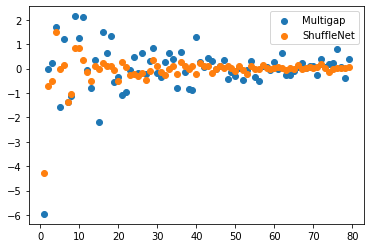

In [13]:
i_element = 100
feats_range = (1, 80)

print(f'Scatter of {i_element} vector with given range {feats_range}')

plt.scatter(np.arange(feats_range[0], feats_range[1]), benchmark_multigap_feats[i_element][feats_range[0]:feats_range[1]], label='Multigap');
plt.scatter(np.arange(feats_range[0], feats_range[1]), benchmark_shufflenet_feats[i_element][feats_range[0]:feats_range[1]], label='ShuffleNet');
plt.legend()
plt.show();